In [1]:
from library.scoreCalculatorLibrary import calculate_score

In [2]:
import os
import pandas as pd
import pickle

In [3]:
# converts hour:minute:seconds to seconds
def time_as_int(timestr):
    hh, mm, ss = timestr.split(":")
    time_int = (int(hh)*3600)+(int(mm)*60)+int(ss)
    return time_int

In [4]:
# name = "prantika_bus_stand"
# name = "junction_mall"
name = "54ft_road"
# name = "dvc_more"
# name = "station"

In [5]:
parent_dir = r"../data/54ft/"
results_csv_name = f"Predictions_merged_54ft_{name}_zone.csv"
reports_dir = f"../reports/54ft/{name}"
plots_dir_name = r"score_plots&correlations"
instance_score_dir = r"instance_wise_scores"
scores_pickle = f"scores_pickle_{name}"

column = 'instance_date'

In [6]:
os.makedirs(reports_dir, exist_ok=True)
os.makedirs(os.path.join(reports_dir, plots_dir_name), exist_ok=True)
os.makedirs(os.path.join(reports_dir, instance_score_dir), exist_ok=True)

In [7]:
result_df = pd.read_csv(os.path.join(parent_dir, results_csv_name))
date_group = result_df.groupby(column)

In [8]:
keys = list(date_group.groups.keys())
all_scores = {}
instance_scores = {}
instances_count = {}
for key in keys:
    df = date_group.get_group(key).copy()
    df["instance_start_time"] = df["instance_start_time"].apply(lambda x: time_as_int(x))
    df["instance_end_time"] = df["instance_end_time"].apply(lambda x: time_as_int(x))
    overall_score, list_scores, no_of_instances = calculate_score(df)
    all_scores[key] = overall_score
    instance_scores[key] = list_scores
    instances_count[key] = no_of_instances

In [9]:
all_scores

{'09/14/2019': 0.3779644730092272,
 '09/15/2019': -0.17413578765820503,
 '09/16/2019': 1.0690449676496976,
 '09/17/2019': 0.0,
 '09/20/2019': 0.0,
 '09/21/2019': 1.0690449676496976,
 '09/23/2019': 0.7276068751089989}

In [10]:
instances_count

{'09/14/2019': 7,
 '09/15/2019': 9,
 '09/16/2019': 14,
 '09/17/2019': 16,
 '09/20/2019': 10,
 '09/21/2019': 14,
 '09/23/2019': 17}

## creating instance wise score df

In [11]:
def generate_time_list(df, time_column):
    times = []
    
    for index, row in df.iterrows():
        condition = row["Prediction Is_Adhoc"] == "Adhoc" or row["Prediction Is_Bus_stop"] == "Bus_stop" \
        or row["Prediction Is_Signal"] == "Signal" or row["Prediction Is_Congestion"] == "Congestion"
        if condition:
            times.append(row[time_column])
        else:
            pass
    
    return times

In [12]:
def generate_instance_score_df(start_times, end_times, scores):
    df = pd.DataFrame(columns=['start_time', 'end_time', 'score'])
    df['start_time'] = start_times
    df['end_time'] = end_times
    df['score'] = scores
    return df

In [13]:
def format_date(mmddyyyy):
    mmddyyyy = mmddyyyy.split("/")
    ddmmyyyy = f"{mmddyyyy[1]}_{mmddyyyy[0]}_{mmddyyyy[2]}"
    return ddmmyyyy

In [14]:
instance_score_dfs = {}
instance_start_times = {}
instance_end_times = {}
for key in keys:
    df = date_group.get_group(key).copy()
    start_times = generate_time_list(df, 'instance_start_time')
    end_times = generate_time_list(df, 'instance_end_time')
    instance_start_times[key] = start_times
    instance_end_times[key] = end_times
    instance_score_dfs[key] = generate_instance_score_df(start_times, end_times, instance_scores[key])

In [15]:
for key in instance_score_dfs:
    csv_name = format_date(key)
    path = os.path.join(reports_dir, instance_score_dir, f"{csv_name}.csv")
    df = instance_score_dfs[key]
    print(f"{key}: {len(df)}")
    df.to_csv(path, index=False)

09/14/2019: 7
09/15/2019: 9
09/16/2019: 14
09/17/2019: 16
09/20/2019: 10
09/21/2019: 14
09/23/2019: 17


## Plots

In [16]:
import matplotlib.pyplot as plt

### Boxplot

In [17]:
data = [instance_scores.get(key) for key in instance_scores.keys()]

#### Saving Scores Pickle

In [18]:
with open(os.path.join(reports_dir, scores_pickle), "wb") as outfile:
    pickle.dump(data, outfile)

#### Plotting

C:\Users\ddsme\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


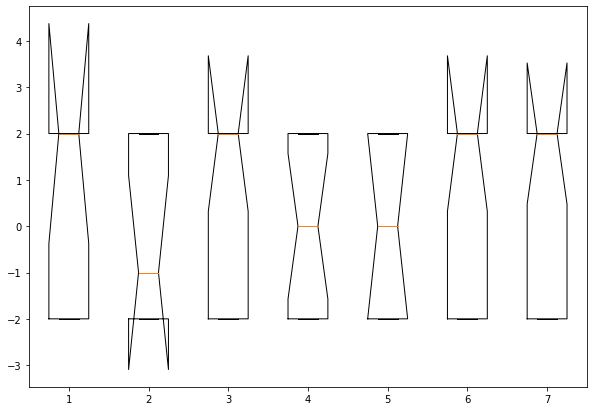

In [19]:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot()
ax.boxplot(data, notch=True)
fig.savefig(os.path.join(reports_dir, plots_dir_name, "boxplot.png"))
plt.show()

###  View plots

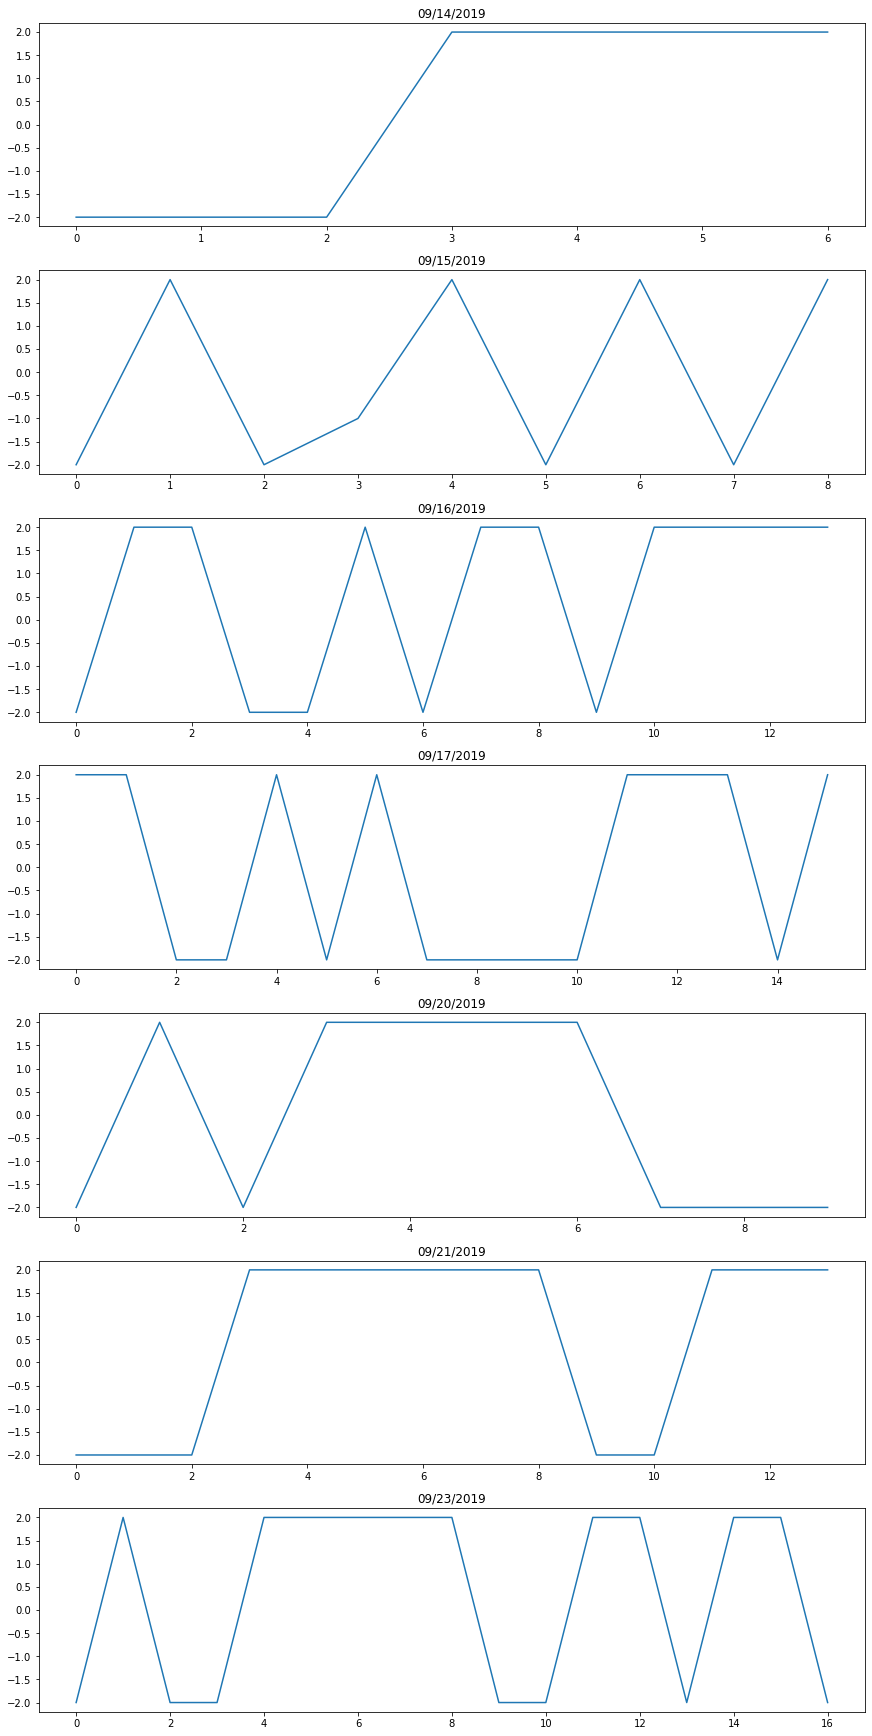

In [20]:
fig, axes = plt.subplots(len(instance_scores), 1, squeeze=False, figsize=(12, 24), constrained_layout=True)
keys = list(instance_scores.keys())
key_index = 0
for key, ax in zip(instance_scores, axes.flat):
    ax.plot(instance_scores.get(key))
    ax.set_title(key)

### Save Plots

In [21]:
for key in instance_scores:
    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot()
    ax.plot(instance_scores.get(key))
    ax.set_title(key)
    outname = "-".join(key.split("/"))
    fig.savefig(os.path.join(reports_dir, plots_dir_name, f"{outname}.png"))
    plt.close(fig)

## Correlation

In [22]:
from library.correlationAndTtestLib import *

In [23]:
pairs_with_scores = form_pairs_with_scores(instance_scores)
print("Total pairs formed: %d" %len(pairs_with_scores))

Total pairs formed: 21


### Kendalltau

In [24]:
kendalltau_correlations, pair_instance_count = kendalltau_corr(pairs_with_scores)
kendalltau_correlations

{('09/14/2019', '09/15/2019'): (0.29814239699997197, 0.4450087187467361),
 ('09/14/2019', '09/16/2019'): (-0.41666666666666674, 0.30743416592739536),
 ('09/14/2019', '09/17/2019'): (-0.16666666666666669, 0.6830913983096087),
 ('09/14/2019', '09/20/2019'): (0.7302967433402215, 0.07363827012030272),
 ('09/14/2019', '09/21/2019'): (1.0, 0.014305878435429634),
 ('09/14/2019', '09/23/2019'): (0.41666666666666674, 0.30743416592739536),
 ('09/15/2019', '09/16/2019'): (-0.22821773229381923, 0.5023349543605022),
 ('09/15/2019', '09/17/2019'): (0.45643546458763845, 0.17971249487899987),
 ('09/15/2019', '09/20/2019'): (0.45643546458763845, 0.17971249487899987),
 ('09/15/2019', '09/21/2019'): (0.2405626121623441, 0.4795001221869535),
 ('09/15/2019', '09/23/2019'): (0.4811252243246882, 0.15729920705028522),
 ('09/16/2019', '09/17/2019'): (-0.14907119849998596, 0.5909334376847462),
 ('09/16/2019', '09/20/2019'): (-0.2, 0.5485062355001471),
 ('09/16/2019', '09/21/2019'): (0.06666666666666667, 0.81004

In [25]:
pair_instance_count

{('09/14/2019', '09/15/2019'): 7,
 ('09/14/2019', '09/16/2019'): 7,
 ('09/14/2019', '09/17/2019'): 7,
 ('09/14/2019', '09/20/2019'): 7,
 ('09/14/2019', '09/21/2019'): 7,
 ('09/14/2019', '09/23/2019'): 7,
 ('09/15/2019', '09/16/2019'): 9,
 ('09/15/2019', '09/17/2019'): 9,
 ('09/15/2019', '09/20/2019'): 9,
 ('09/15/2019', '09/21/2019'): 9,
 ('09/15/2019', '09/23/2019'): 9,
 ('09/16/2019', '09/17/2019'): 14,
 ('09/16/2019', '09/20/2019'): 10,
 ('09/16/2019', '09/21/2019'): 14,
 ('09/16/2019', '09/23/2019'): 14,
 ('09/17/2019', '09/20/2019'): 10,
 ('09/17/2019', '09/21/2019'): 14,
 ('09/17/2019', '09/23/2019'): 16,
 ('09/20/2019', '09/21/2019'): 10,
 ('09/20/2019', '09/23/2019'): 10,
 ('09/21/2019', '09/23/2019'): 14}

### Welch's T-Test

In [26]:
welch = welch_t(pairs_with_scores)
welch

{('09/14/2019', '09/15/2019'): (0.376710099799021, 0.7126189043410583),
 ('09/14/2019', '09/16/2019'): (-0.295378269592824, 0.7730449911955881),
 ('09/14/2019', '09/17/2019'): (0.297921795862109, 0.7712378076334752),
 ('09/14/2019', '09/20/2019'): (0.2727272727272727, 0.7893640661896824),
 ('09/14/2019', '09/21/2019'): (-0.295378269592824, 0.7730449911955881),
 ('09/14/2019', '09/23/2019'): (-0.07105008687266133, 0.9446656837208105),
 ('09/15/2019', '09/16/2019'): (-0.7938170115911177, 0.43826564726533357),
 ('09/15/2019', '09/17/2019'): (-0.13067670548437801, 0.8975667347200836),
 ('09/15/2019', '09/20/2019'): (-0.11708090166042792, 0.9081752338530368),
 ('09/15/2019', '09/21/2019'): (-0.7938170115911177, 0.43826564726533357),
 ('09/15/2019', '09/23/2019'): (-0.5550857149726514, 0.5863172620301177),
 ('09/16/2019', '09/17/2019'): (0.771046169254443, 0.4472026246080786),
 ('09/16/2019', '09/20/2019'): (0.6701763024693984, 0.5108873424161524),
 ('09/16/2019', '09/21/2019'): (0.0, 1.0),
